<a href="https://colab.research.google.com/github/plthiyagu/AI-Engineering/blob/master/Multiple_Time_Series_Forecasting_using_Gluon_TS_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
#!pip install --upgrade mxnet-cu101==1.6.0
!pip install --upgrade mxnet==1.6.0
!pip install gluonts

Requirement already up-to-date: mxnet==1.6.0 in /usr/local/lib/python3.6/dist-packages (1.6.0)


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [26]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00321/LD2011_2014.txt.zip
!unzip  LD2011_2014.txt.zip

In [53]:
!head LD2011_2014.txt

"";"MT_001";"MT_002";"MT_003";"MT_004";"MT_005";"MT_006";"MT_007";"MT_008";"MT_009";"MT_010";"MT_011";"MT_012";"MT_013";"MT_014";"MT_015";"MT_016";"MT_017";"MT_018";"MT_019";"MT_020";"MT_021";"MT_022";"MT_023";"MT_024";"MT_025";"MT_026";"MT_027";"MT_028";"MT_029";"MT_030";"MT_031";"MT_032";"MT_033";"MT_034";"MT_035";"MT_036";"MT_037";"MT_038";"MT_039";"MT_040";"MT_041";"MT_042";"MT_043";"MT_044";"MT_045";"MT_046";"MT_047";"MT_048";"MT_049";"MT_050";"MT_051";"MT_052";"MT_053";"MT_054";"MT_055";"MT_056";"MT_057";"MT_058";"MT_059";"MT_060";"MT_061";"MT_062";"MT_063";"MT_064";"MT_065";"MT_066";"MT_067";"MT_068";"MT_069";"MT_070";"MT_071";"MT_072";"MT_073";"MT_074";"MT_075";"MT_076";"MT_077";"MT_078";"MT_079";"MT_080";"MT_081";"MT_082";"MT_083";"MT_084";"MT_085";"MT_086";"MT_087";"MT_088";"MT_089";"MT_090";"MT_091";"MT_092";"MT_093";"MT_094";"MT_095";"MT_096";"MT_097";"MT_098";"MT_099";"MT_100";"MT_101";"MT_102";"MT_103";"MT_104";"MT_105";"MT_106";"MT_107";"MT_108";"MT_109";"MT_110";"MT_111

In [27]:
df= pd.read_csv("LD2011_2014.txt",sep=";",index_col=0,parse_dates=True,decimal=',')
df.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,...,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_337,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_347,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,129.629630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,119.212963,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,127.314815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,125.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,122.685185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df.columns

Index(['MT_001', 'MT_002', 'MT_003', 'MT_004', 'MT_005', 'MT_006', 'MT_007',
       'MT_008', 'MT_009', 'MT_010',
       ...
       'MT_361', 'MT_362', 'MT_363', 'MT_364', 'MT_365', 'MT_366', 'MT_367',
       'MT_368', 'MT_369', 'MT_370'],
      dtype='object', length=370)

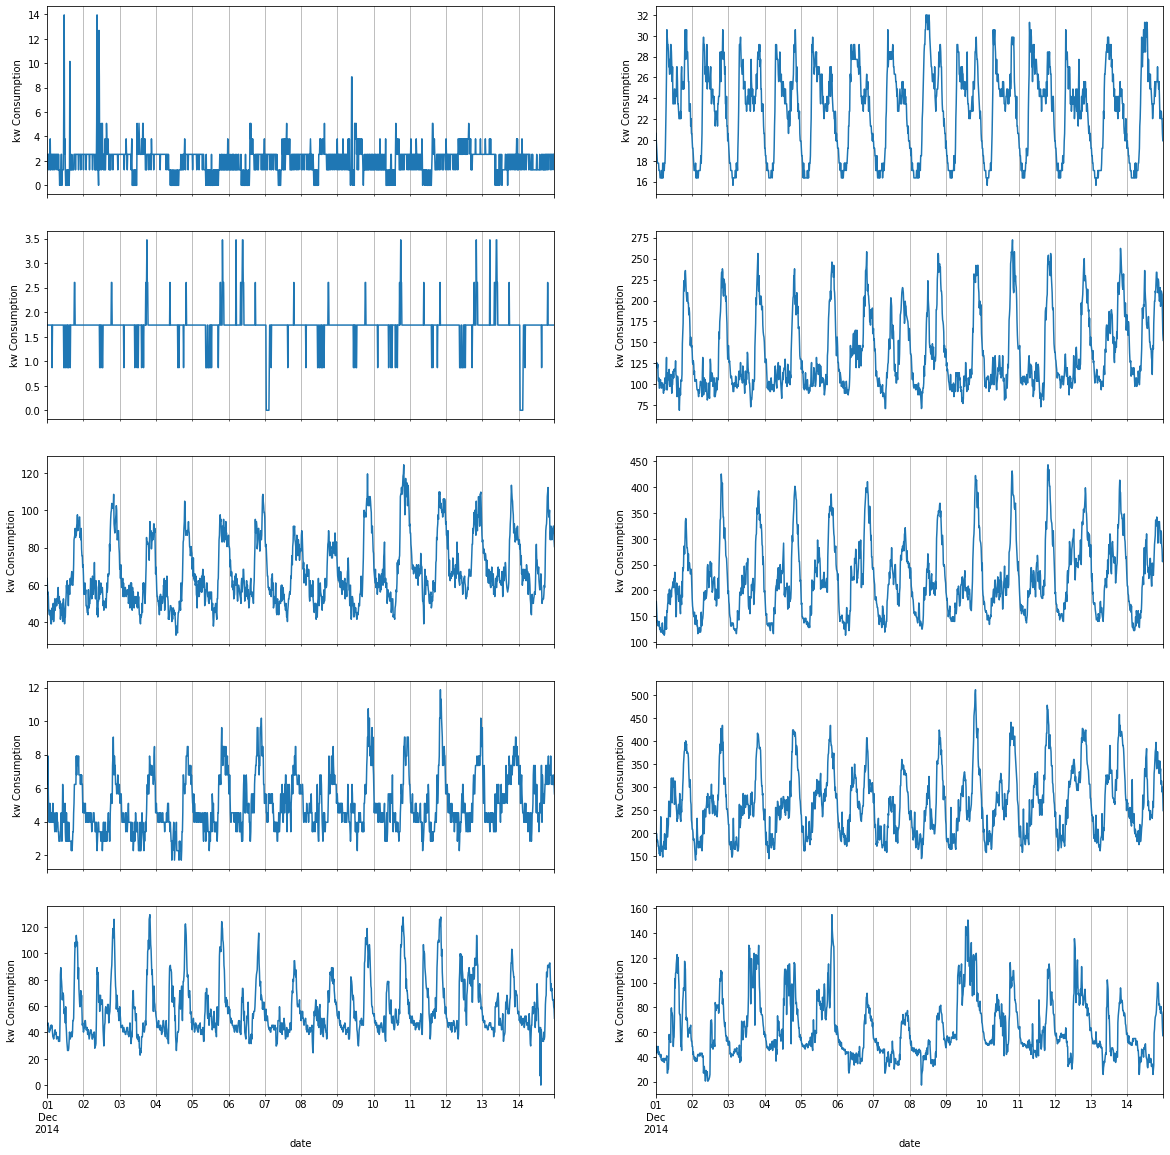

In [5]:
fig,axs = plt.subplots(5,2, figsize=(20,20),sharex=True)
axx = axs.ravel()
for i in range(0,10):
  df[df.columns[i]].loc["2014-12-01":"2014-12-14"].plot(ax=axx[i])
  axx[i].set_xlabel("date")
  axx[i].set_ylabel("kw Consumption")
  axx[i].grid(which='minor',axis='x')


In [6]:
df_input=df.reset_index(drop=True).T.reset_index()

In [7]:
df_input

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,140216,140217,140218,140219,140220,140221,140222,140223,140224,140225,140226,140227,140228,140229,140230,140231,140232,140233,140234,140235,140236,140237,140238,140239,140240,140241,140242,140243,140244,140245,140246,140247,140248,140249,140250,140251,140252,140253,140254,140255
0,MT_001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.269036,1.269036,1.269036,2.538071,3.807107,6.345178,2.538071,2.538071,2.538071,3.807107,2.538071,2.538071,2.538071,1.269036,1.269036,2.538071,2.538071,1.269036,2.538071,2.538071,1.269036,2.538071,2.538071,1.269036,2.538071,2.538071,2.538071,1.269036,2.538071,3.807107,2.538071,1.269036,2.538071,2.538071,1.269036,2.538071,2.538071,2.538071,1.269036,2.538071
1,MT_002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,27.027027,25.604552,27.027027,26.315789,29.160740,29.160740,29.871977,29.160740,29.160740,28.449502,28.449502,29.871977,29.160740,26.315789,27.738265,27.738265,29.160740,28.449502,29.160740,29.160740,28.449502,28.449502,27.027027,26.315789,25.604552,25.604552,23.470839,22.759602,23.470839,22.759602,22.048364,22.048364,22.048364,22.048364,22.048364,22.048364,21.337127,20.625889,21.337127,19.914651
2,MT_003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.737619,0.868810,1.737619,1.737619,1.737619,1.737619,0.868810,1.737619,1.737619,1.737619,1.737619,1.737619,2.606429,1.737619,2.606429,3.475239,2.606429,2.606429,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619,1.737619
3,MT_004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,132.113821,128.048780,146.341463,144.308943,146.341463,144.308943,126.016260,140.243902,152.439024,162.601626,162.601626,164.634146,152.439024,160.569106,189.024390,205.284553,199.186992,205.284553,217.479675,215.447154,227.642276,205.284553,193.089431,195.121951,193.089431,189.024390,168.699187,162.601626,168.699187,160.569106,156.504065,164.634146,160.569106,162.601626,156.504065,150.406504,166.666667,162.601626,166.666667,178.861789
4,MT_005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,73.170732,69.512195,57.317073,59.756098,60.975610,60.975610,62.195122,54.878049,63.414634,71.951220,75.609756,68.292683,63.414634,65.853659,74.390244,85.365854,87.804878,86.585366,89.024390,92.682927,102.439024,95.121951,91.463415,96.341463,91.463415,90.243902,90.243902,87.804878,87.804878,82.926829,86.585366,93.902439,87.804878,80.487805,85.365854,85.365854,81.707317,82.926829,85.365854,84.146341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,MT_366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.510825,3.510825,3.510825,3.510825,7.606788,3.510825,3.510825,4.681100,4.681100,7.606788,7.606788,8.777063,9.362200,9.362200,9.947338,9.947338,6.436513,4.095963,3.510825,4.095963,4.095963,3.510825,6.436513,5.851375,4.095963,4.095963,3.510825,4.681100,3.510825,4.095963,3.510825,6.436513,11.702750

In [28]:
ts_code= df_input['index'].astype('category').cat.codes.values

In [29]:
ts_code

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [32]:
df_train =df_input.iloc[:,1:134999].values
df_test =df_input.iloc[:,134999:].values

In [33]:
df_train.shape

(370, 134998)

In [34]:
df_test.shape

(370, 5258)

In [35]:
freq ="15min"
start_train = pd.Timestamp("2011-01-01 00:15:00",freq=freq)
start_test = pd.Timestamp("2011-11-07 00:15:00",freq=freq)
prediction_length = 672

In [36]:
estimator = DeepAREstimator(freq=freq,
                            context_length =672,
                            prediction_length = prediction_length,
                            use_feat_static_cat= True,
                            cardinality=[1],
                            num_layers =2,
                            num_cells =32,
                            cell_type ='lstm',
                            trainer= Trainer(epochs=5)
                            )


In [37]:
df_train[0:7]

array([[  0.        ,   0.        ,   0.        , ...,   2.53807107,
          2.53807107,   1.26903553],
       [  0.        ,   0.        ,   0.        , ...,  17.06970128,
         17.78093883,  17.78093883],
       [  0.        ,   0.        ,   0.        , ...,   1.73761946,
          1.73761946,   1.73761946],
       ...,
       [  0.        ,   0.        ,   0.        , ...,  47.56097561,
         43.90243902,  43.90243902],
       [  0.        ,   0.        ,   0.        , ..., 107.14285714,
        116.07142857,  98.21428571],
       [  0.        ,   0.        ,   0.        , ...,   4.522329  ,
          4.522329  ,   3.95703787]])

In [39]:
from gluonts.dataset.common  import ListDataset
from gluonts.dataset.field_names import FieldName

train_ds= ListDataset([
                       {
                           FieldName.TARGET:target,
                           FieldName.START:start_train,
                           FieldName.FEAT_STATIC_CAT:fsc
                       }
                       for (target,fsc) in zip(df_train[0:7],
                                               ts_code[0:7].reshape(-1,1))

], freq=freq)

test_ds= ListDataset([
                       {
                           FieldName.TARGET:target,
                           FieldName.START:start_test,
                           FieldName.FEAT_STATIC_CAT:fsc
                       }
                       for (target,fsc) in zip(df_test[0:7],
                                               ts_code[0:7].reshape(-1,1))

], freq=freq)

In [40]:
next(iter(train_ds))

{'feat_static_cat': array([0], dtype=int32),
 'source': SourceContext(source='list_data', row=0),
 'start': Timestamp('2011-01-01 00:15:00', freq='15T'),
 'target': array([0.       , 0.       , 0.       , ..., 2.5380712, 2.5380712,
        1.2690356], dtype=float32)}

In [43]:
predictor = estimator.train(training_data=train_ds)

Exception ignored in: <bound method ParallelDataLoader.__del__ of <gluonts.dataset.parallelized_loader.ParallelDataLoader object at 0x7fb84de00710>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/gluonts/dataset/parallelized_loader.py", line 686, in __del__
    if self.worker_pool:
AttributeError: 'ParallelDataLoader' object has no attribute 'worker_pool'


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.




  2%|▏         | 1/50 [00:35<28:51, 35.34s/it, epoch=1/5, avg_epoch_loss=3.75]

 12%|█▏        | 6/50 [00:47<18:41, 25.49s/it, epoch=1/5, avg_epoch_loss=3.76]

 12%|█▏        | 6/50 [00:59<18:41, 25.49s/it, epoch=1/5, avg_epoch_loss=3.5] 

 22%|██▏       | 11/50 [01:01<12:07, 18.65s/it, epoch=1/5, avg_epoch_loss=3.47]

 30%|███       | 15/50 [01:11<08:03, 13.82s/it, epoch=1/5, avg_epoch_loss=3.27]

 30%|███       | 15/50 [01:23<08:03, 13.82s/it, epoch=1/5, avg_epoch_loss=3.17]

 40%|████      | 20/50 [01:23<05:12, 10.41s/it, epoch=1/5, avg_epoch_loss=3.15]

 50%|█████     | 25/50 [01:36<03:21,  8.05s/it, epoch=1/5, avg_epoch_loss=3.1] 

 58%|█████▊    | 29/50 [01:47<02:15,  6.44s/it, epoch=1/5, avg_epoch_loss=3.03]

 68%|██████▊   | 34/50 [01:59<01:24,  5.26s/it, epoch=1/5, avg_epoch_loss=2.98]

 68%|██████▊   | 34/50 [02:09<01:24,  5.26s/it, epoch=1/5, avg_epoch_loss=2.93]

 78%|███████▊  | 39/50 [02:11<00:48,  4.39s/it, epoch=1/5, avg_epoch_loss=2.94]

 78%|███████▊  | 39/50 [02:23

In [44]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it,ts_it = make_evaluation_predictions(
    dataset =test_ds,
    predictor= predictor,
    num_samples=100,
)

In [45]:
from tqdm.autonotebook import tqdm

print("Obtaining time series conditioning values.....")
tss = list(tqdm(ts_it,total=len(df_test)))

print("Obtaining time series prediction.....")
forecasts = list(tqdm(forecast_it,total=len(df_test)))


Obtaining time series conditioning values.....



Obtaining time series prediction.....


In [46]:
def plot_prob_forecasts(ts_entry,forecast_entry):
  plot_length= prediction_length
  prediction_intervals=(80.0,95.0)
  legend= ["observations","median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

  fig,ax = plt.subplots(1,1, figsize=(10,7))
  ts_entry[-plot_length:].plot(ax=ax)
  forecast_entry.plot(prediction_intervals=prediction_intervals,color='g')
  plt.grid(which="both")
  plt.legend(legend,loc="upper left")
  plt.show()

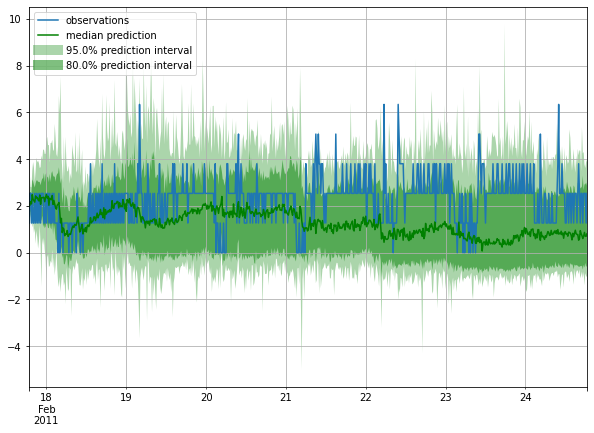

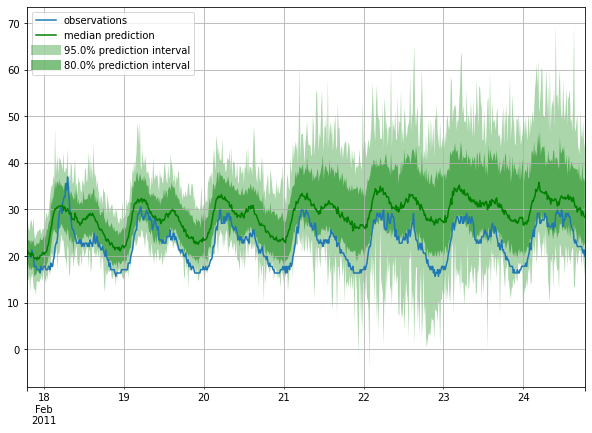

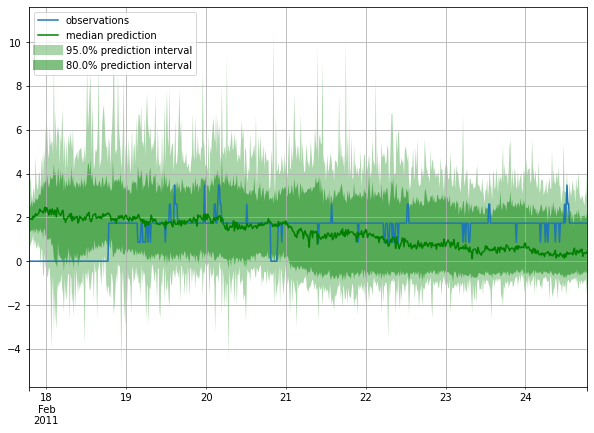

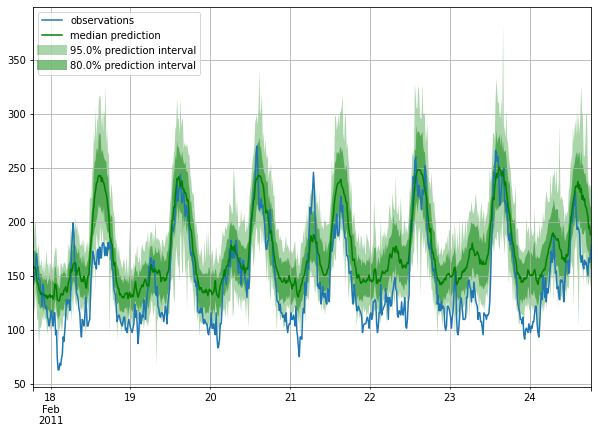

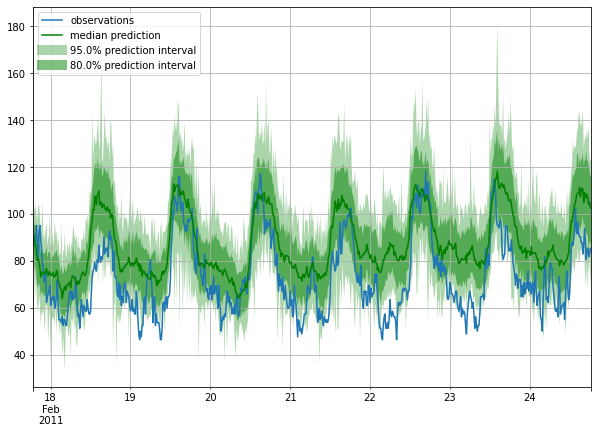

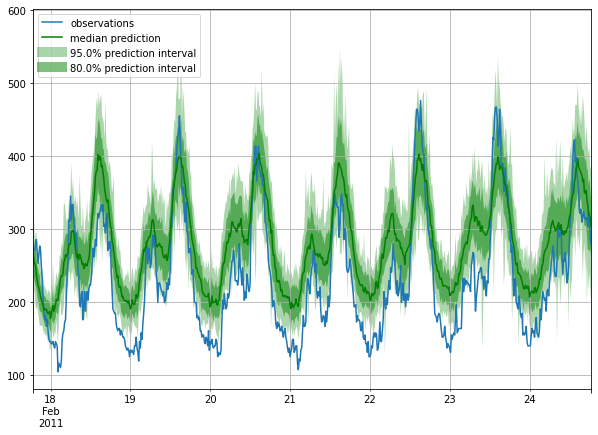

In [47]:
for i in tqdm(range(6)):
  ts_entry = tss[i]
  forecast_entry = forecasts[i]
  plot_prob_forecasts(ts_entry,forecast_entry)

In [49]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1,0.5,0.9])
agg_metrics,item_metrics=evaluator(iter(tss),iter(forecasts),num_series=len(df_test[0:7]))



Running evaluation: 100%|██████████| 7/7 [00:00<00:00, 129.69it/s]WARNING:root:multiple 15 does not divide base seasonality 1.Falling back to seasonality 1



In [50]:
item_metrics

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,OWA,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,NaN,2.127539,842.011169,1513.959351,2.252916,0.839750,1.492102,0.459717,0.729169,NaN,7.727218,336.626828,0.023810,842.011151,0.184524,304.924814,0.822917
1,NaN,47.243088,4071.614258,15320.056641,22.797703,0.811912,7.462567,0.286394,0.243485,NaN,34.431980,1689.444981,0.656250,4071.614313,0.979167,1692.810437,0.995536
2,NaN,1.121192,603.265198,984.361450,1.464824,0.114831,7.817736,0.336886,0.774467,NaN,57.099614,341.086085,0.135417,603.265189,0.345238,225.806333,0.986607
3,NaN,1049.767299,18814.923828,98455.281250,146.510835,8.946636,3.129489,0.222356,0.191897,NaN,26.370998,13870.754553,0.622024,18814.924549,0.889881,6600.431158,0.982143
4,NaN,259.593471,9471.087891,49303.656250,73.368536,4.198207,3.357119,0.213942,0.186349,NaN,21.982248,5909.930429,0.590774,9471.087421,0.903274,3421.606223,0.992560
5,NaN,3456.491071,36034.093750,157196.437500,233.923270,13.675547,3.921025,0.277536,0.234799,NaN,39.101950,31202.647034,0.714286,36034.093964,0.875000,11971.060907,0.953869
6,NaN,6.430020,1309.503174,3665.913086,5.455228,0.594141,3.279802,0.404682,0.340035,NaN,27.254332,655.539912,0.056548,1309.503119,0.677083,765.822454,0.931548
